In [1]:
# MNIST Handwritten Digit Classification
import os
import torch
import torch.nn as nn               # to load neural network functionality
import torch.nn.functional as nnF       # Adds efficiency
from torch.utils.data import DataLoader # Data loading in batches
from torchvision import datasets, transforms
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix # For evaluating results
import matplotlib.pyplot as plt
%matplotlib inline
import time
torch.manual_seed(2002) # setting seed for consistent results


In [14]:
transformer = transforms.ToTensor()
#print(os.getcwd()) # For debugging :D lol folder problems
train_data = datasets.MNIST(root='\data', train=True, download=False, transform=transformer) # loading the training data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: \data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [16]:
test_data = datasets.MNIST(root='\data', train=False, download=False, transform=transformer) # Loading the test data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: \data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [54]:
image, label = train_data[18]
print('Image shape:', image.shape, '\nImage Label:', label)

Image shape: torch.Size([1, 28, 28]) 
Image Label: 6


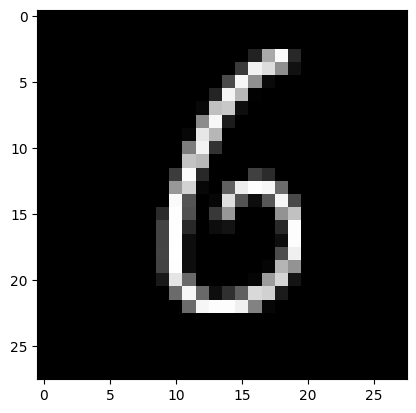

In [55]:
plt.imshow(image.reshape((28,28)), cmap="gray") # Gray colormap for only one channel

In [65]:
# Establishing data loaders for batch data loading for training and testing sets
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [66]:
class MP(nn.Module): # MP = short for MultilayerPerceptron
    # The input size is the flattened 2D-image array, from [[28,28]] -> [784] or smth
    # Takes 120 inputs and has 84 neurons, output size is 10, since 0-9 is the range we are dealing with.
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        # With PyTorch, there is no need to create a separate input layer, it handles the input for you :)
        self.hl1 = nn.Linear(input_size, layers[0])  # Hidden layer 1 for computation
        self.hl2 = nn.Linear(layers[0], layers[1])   # Hidden layer 2   
        self.ol = nn.Linear(layers[1], output_size) # Output layer

    def forward(self, X):
        X = nnF.relu(self.hl1(X))
        X = nnF.relu(self.hl2(X))
        X = self.ol(X)
        return nnF.log_softmax(X, dim=1) # Applying a softmax limit with a logarithm function
        

In [67]:
model = MP()
print(model)

MP(
  (hl1): Linear(in_features=784, out_features=120, bias=True)
  (hl2): Linear(in_features=120, out_features=84, bias=True)
  (ol): Linear(in_features=84, out_features=10, bias=True)
)


In [68]:
# Optimizing the model for trying to minimize loss throughtout iterations
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [69]:
for images, labels in train_loader:
    print("Batch shape at start:", images.size())
    break
print("Batch shape after flattening:", images.view(100, -1).size())

Batch shape at start: torch.Size([100, 1, 28, 28])
Batch shape after flattening: torch.Size([100, 784])


In [ ]:
# Training the model
n_epochs = 10 # Number of epochs to train the model on

model.train() # Preparing model for training

for epoch in range(n_epochs):
    # Monitorin training loss
    train_loss = 0.0
    
    for data, target in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        data = data.view(data.shape[0], -1) # Reshaping the data
        # Compute predicted outputs by passing inputs to the model
        output = model(data)
        loss = criteria(output, target)
        # Compute gradient of the loss with respect to the model parameters
        loss.backward()
        # Perform a single parameter update
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
    
    # Print training stats and calculate average loss between epochs
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
